In [13]:
import math
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt

In [19]:
pd.options.display.max_rows = 30
df = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/train.csv')
df_test = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/test.csv')
valid = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/sample_submission.csv')

In [20]:
X_train = df.drop(['SalePrice', 'Id'], axis=1)
y_train = df['SalePrice']

X_test = df_test.drop(['Id'], axis=1)
y_valid = valid.drop(['Id'], axis=1)

In [21]:
 # remove outliers
'''df = df.drop([691, 1182, 1169, 898, 803])
df.index = range(df.shape[0])'''

'df = df.drop([691, 1182, 1169, 898, 803])\ndf.index = range(df.shape[0])'

In [37]:
def learn(model):
    df = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/train.csv')
    df_test = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/test.csv')
    valid = pd.read_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/sample_submission.csv')
    
    X_train = df.drop(['SalePrice', 'Id'], axis=1)
    y_train = df['SalePrice']

    X_test = df_test.drop(['Id'], axis=1)
    y_valid = valid.drop(['Id'], axis=1)

    numerical_col = [column for column in X_train.columns if (X_train[column].dtype in ['int64', 'float64'])]
    categorical_col = list(set(X_train.columns) - set(numerical_col))

    def nan_threshold(X, categorical_col):
        threshold = 0.2
        for col in categorical_col:
            if (X[col].isna().sum()/len(X.index) > threshold) or (X[col].nunique() > 10):
                categorical_col.remove(col)


    nan_threshold(X_train, categorical_col)

    imputer = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
    X_train[categorical_col] = imputer.fit_transform(X_train[categorical_col])
    X_test[categorical_col] = imputer.fit_transform(X_test[categorical_col])
    ohe = OneHotEncoder()
    ohe.fit(X_train[categorical_col])
    ohe_train = pd.DataFrame(ohe.transform(X_train[categorical_col]).toarray())
    ohe_test = pd.DataFrame(ohe.transform(X_test[categorical_col]).toarray())

    ordinal_col = ['ExterQual', 'BsmtQual', 'KitchenQual', 'Functional', 'GarageCond', 'LandSlope', 'BsmtFinType2', 
                    'GarageQual', 'CentralAir', 'BsmtFinType1', 'BsmtCond', 'PavedDrive', 'ExterCond', 'HeatingQC',
                    'GarageFinish']

    def discrete_ordinals(X):
        quality1 = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageCond', 'GarageQual', 'BsmtCond', 'ExterCond', 'HeatingQC']
        quality2 = ['Functional']
        quality3 = ['LandSlope']
        quality4 = ['BsmtFinType1', 'BsmtFinType2']
        quality5 = ['CentralAir', 'PavedDrive']
        quality6 = ['GarageFinish']

        order1 = [np.NaN, 'Po', 'Fa', 'TA', 'Gd', 'Ex']
        order2 = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
        order3 = ['Sev', 'Mod', 'Gtl']
        order4 = [np.NaN, 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
        order5 = ['N', 'P', 'Y']
        order6 = [np.NaN, 'Unf', 'RFn', 'Fin']

        quality_array = [(quality1, order1), (quality2, order2), (quality3, order3),
                         (quality4, order4), (quality5, order5), (quality6, order6)]

        def assign_values(order):
            return {label: index for index, label in enumerate(order)}

        for (cat, order) in quality_array:
            for col in cat:
                X[col] = X[col].map(assign_values(order))
                
    discrete_ordinals(X_train)
    discrete_ordinals(X_test)

    categorical_col = list(set(categorical_col)-set(ordinal_col))

    X_train = X_train[numerical_col+ordinal_col+categorical_col]
    X_test = X_test[numerical_col+ordinal_col+categorical_col]

    
    numerical_transformer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    numerical_transformer.fit(X_train[numerical_col+ordinal_col])
    X_train[numerical_col+ordinal_col] = numerical_transformer.fit_transform(X_train[numerical_col+ordinal_col])
    X_test[numerical_col+ordinal_col] = numerical_transformer.transform(X_test[numerical_col+ordinal_col])
    
    if model not in [logistic_regr]:
        scaler = RobustScaler()
        X_train[numerical_col] = scaler.fit_transform(X_train[numerical_col])
        X_test[numerical_col] = scaler.fit_transform(X_test[numerical_col])

    categorical_transformer.fit(X_train[categorical_col])
    ohe_train = pd.DataFrame(categorical_transformer.fit_transform(X_train[categorical_col]).toarray())
    ohe_test = pd.DataFrame(categorical_transformer.transform(X_test[categorical_col]).toarray())


    X_train = pd.concat([X_train[numerical_col+ordinal_col], ohe_train], axis=1)
    X_test = pd.concat([X_test[numerical_col+ordinal_col], ohe_test], axis=1)

    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)

    '''I don't have dataset to check correctness of results but sample submissions were attached 
        on the site so I can at least compare lines on the plots (mse, rmse, rmsle etc. can also
        illustrate correctness in a way in this case...)'''
    
    print(f'model: {model}')
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_prediction))
    print("Root Mean squared error: %.2f"
          % math.sqrt(mean_squared_error(y_valid, y_prediction)))
    print('Root Mean squared log error: %.4f'
          % mean_squared_log_error(y_valid, y_prediction))
    print('R2 score: %.2f' 
          % r2_score(y_valid, y_prediction))
    print("Mean Absolute Percentage Error: %.2f\n"
          % mean_absolute_percentage_error(y_valid, y_prediction))
    
    def plot_comparision(y_valid, y_prediction):
        data = [[y_valid.SalePrice[i], y_prediction[i]] for i in range(0,len(y_prediction))]
        results = pd.DataFrame(data=data, columns=['y_valid', 'y_prediction'])
        fix, ax = plt.subplots(figsize=(10,10))
        ax.scatter(results.index, y_valid.SalePrice.sort_values(), color='green')
        ax.scatter(results.index, pd.Series(y_prediction).sort_values(), color='brown')
        ax.legend(['Real', 'Predicted'])
        plt.xlabel("House")
        plt.ylabel("Price")
        plt.title(f'Predicted vs Real - {model}')

    plot_comparision(y_valid, y_prediction)

    return y_prediction

model: RandomForestRegressor(n_estimators=15, random_state=0)
Mean squared error: 4663317186.23
Root Mean squared error: 68288.49
Root Mean squared log error: 0.1167
R2 score: -16.10
Mean Absolute Percentage Error: 0.29

model: LinearRegression()
Mean squared error: 5669145175.51
Root Mean squared error: 75293.73
Root Mean squared log error: 0.2126
R2 score: -19.79
Mean Absolute Percentage Error: 0.32



C:\Users\Milosz\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=15, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Mean squared error: 5538698228.04
Root Mean squared error: 74422.43
Root Mean squared log error: 0.1343
R2 score: -19.31
Mean Absolute Percentage Error: 0.30



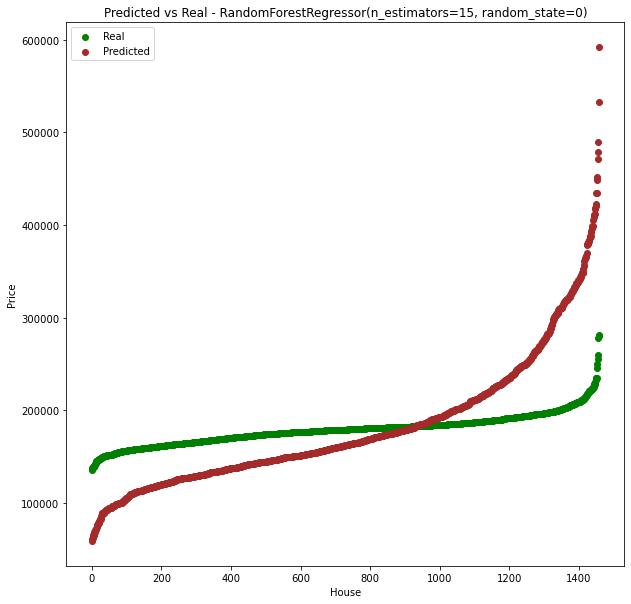

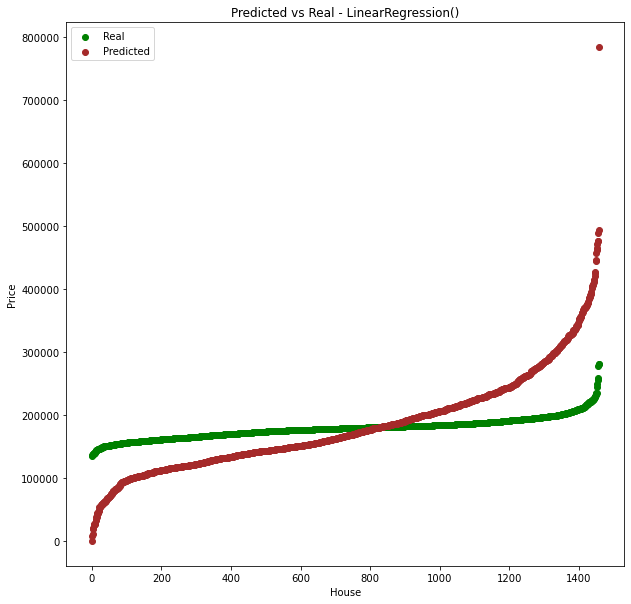

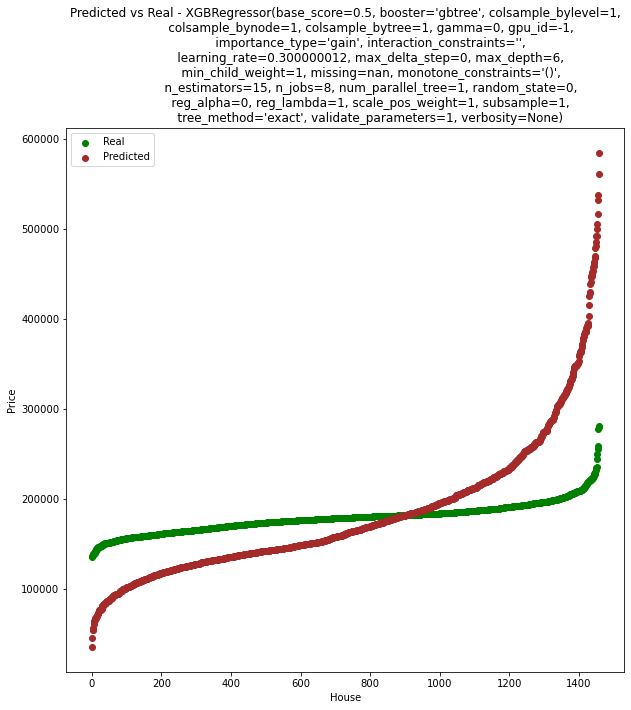

In [38]:
random_forest = RandomForestRegressor(n_estimators = 15, random_state = 0)   #I've made a test which showed that n_estimators=15
                                                                              #is the best choice for this task
linear_regr = LinearRegression(fit_intercept=True, normalize=False)

xgb_regr = xgboost.XGBRegressor(n_estimators=15)

lst = [random_forest, linear_regr, xgb_regr]
for algo in lst:
    learn(algo)

C:\Users\Milosz\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=15, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Mean squared error: 5538698228.04
Root Mean squared error: 74422.43
Root Mean squared log error: 0.1343
R2 score: -19.31
Mean Absolute Percentage Error: 0.30



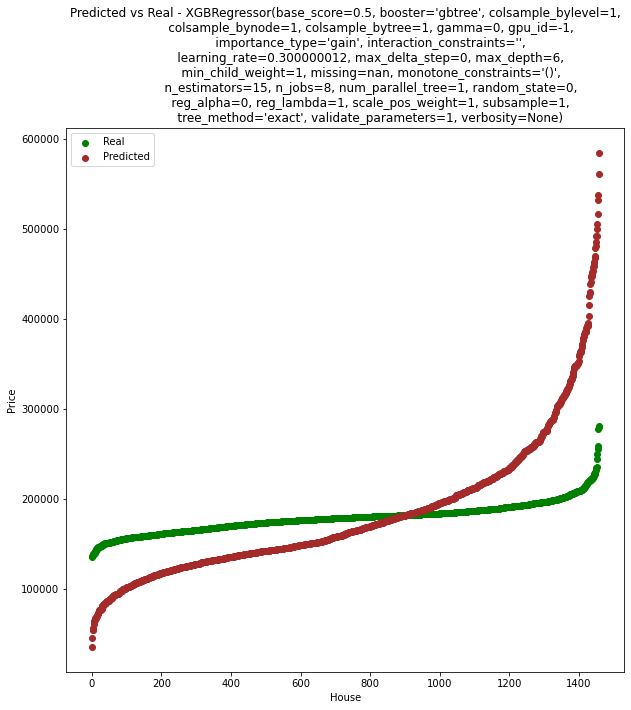

In [30]:
#xgb esult: 0.14209 (best)

results = learn(xgb_regr)
results_df = pd.DataFrame(data=results, columns=['SalePrice'])
results_df['Id'] = results_df.index + 1461
results_df = results_df.set_index('Id')

In [25]:
results_df

,SalePrice
Id,
1461,118692.171875
1462,136325.125000
1463,183554.171875
1464,188436.312500
1465,192888.187500
...,...
2915,89351.625000
2916,85126.195312
2917,163891.109375


In [26]:
results_df.to_csv('C:/Users/Milosz/Desktop/python_programs/JUPYTER/Housing_prices_comp/results1.csv')